# CLASSIFICATION TASK

## Index

1. [Decade Classification](#decade) <br>
   1.1 [Libraries and Data](#data) <br>
   1.2 [Baselines and Design Matrix](#baselines1)<br>
      1.2.1 [Most Frequent Predictor](#most1)<br>
      1.2.2 [The Hulk](#hulk1)<br>
   1.3 [Building on the Baseline](#build)<br>
   1.4 [Support Vector Machines](#svc)<br>
   1.5 [Random Forest](#rf)<br>
   1.6 [Test Performance and Summary](#test)<br>
   
2. [Gender Classification](#gender)<br>
   2.1 [Baselines](#baselines2)<br>
      2.1.1 [Most Frequent Predictor](#most2)<br>
      2.1.2 [The Hulk](#hulk2)<br>
   2.2 [Convolutional Neural Network](#cnn)<br>

## Deacade Classification <a name="decade"></a>

As far as the classification task is concerned, I will try to classify the decades of the songs, coherently with the aims of the research I've carried out so far. I will use the downsampled dataset (10459 observations),  and will split it in train, dev and test data (~80%, 10%, 10%). Finally, the main metric of analisys will be the f1-micro, to correctly account for false positives and false negatives. 
<br>    

For most of the parameters tuning, CV scores results are hidden but readable under the grid search and randomized search cells, and were indeed widely taken into account to choose the next steps to follow. In fact, due to CPU limitations I could not run extensive grid searches for most of the models, and had to carefully choose the parameters space to explore.

I will first import libraries and data, define some useful functions, re obtain the downsampled dataset as shown in the previous notebook and finally split between train, dev and test sets.

## Libraries and Data <a name="data"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# VECTORIZERS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CLASSIFIERS
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

# PREPROCESSING, SELECTION AND DIMENSIONALITY REDUCION
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD

# HYPERPARAMETER TUNING
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

# EVALUATION
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    This function clearly plots the confusion matrix
    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    Compute the proportion of times the performance difference of the two systems on a subsample is significantly different
    from the performance on the entire sample
    """
    
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

Below is the process used to obtain the train, dev and test sets. One can skip 2 cells to directly import the resulting datasets.

In [2]:
# PROCESS FOR RE-DERIVING THE DATASET AND THEN THE TRAIN-DEV-TEST SPLITTING.
songs = pd.read_csv("data/nlp_songs_lemmatized").drop(columns = ["Unnamed: 0"])
songs = songs.dropna().reset_index(drop = True)
songs = songs.drop_duplicates(subset = "lemma")

# Constitution of a downsampled more balanced dataset

_60s = songs[songs["decade"] == "60s"]
_70s = songs[songs["decade"] == "70s"]
_80s = songs[songs["decade"] == "80s"]
_90s = songs[songs["decade"] == "90s"][:2000]
_00s = songs[songs["decade"] == "00s"][:2000]
_10s = songs[songs["decade"] == "10s"][:2000]

songs_bal = pd.concat([_60s, _70s, _80s, _90s, _00s, _10s], axis = 0).sample(frac = 1).reset_index(drop = True)

print("Total number of songs:", len(songs_bal))

Total number of songs: 10459


In [3]:
# TRAIN, DEV AND TEST SPLIT

train = songs_bal.sample(frac = 1, random_state = 1).iloc[:8000,:]
dev = songs_bal.sample(frac = 1, random_state = 1).iloc[8000:9250,:]
test = songs_bal.sample(frac = 1, random_state = 1).iloc[9250:,:]

# train.to_csv("train_decade.csv")
# dev.to_csv("dev_decade.csv")
# test.to_csv("test_decade.csv")

In [8]:
# IMPORTING THE TRAINM DEV AND TEST DATASETS
train = pd.read_csv("data/train_decade.csv").iloc[:,1:]
dev = pd.read_csv("data/dev_decade.csv").iloc[:,1:]
test = pd.read_csv("data/test_decade.csv").iloc[:,1:]

y_train = train.decade
y_dev = dev.decade
y_test = test.decade

tokens_train = train.lemma
tokens_dev = dev.lemma
tokens_test = test.lemma

## BASELINES AND DESIGN MATRIX <a name="baselines1"></a>

Below the main design matrix used followed by the two baselines are reported: an n-gram logit model informally referred to as the "Hulk" and the most frequent predictor, as well as their training and dev performance in the form of classification reports.

In [9]:
# DEFINING THE DESIGN MATRIX

ngram_range = (2,6)
min_df = 0.001
max_df = 0.75
analyzer = "char"

tfidf_vectorizer_base = TfidfVectorizer(analyzer= analyzer,
                                   ngram_range= ngram_range, 
                                   min_df = min_df, 
                                   max_df = max_df, 
                                   stop_words= 'english', 
                                   sublinear_tf=True)

X_base_train = tfidf_vectorizer_base.fit_transform(tokens_train)
X_base_dev = tfidf_vectorizer_base.transform(tokens_dev)
X_base_test = tfidf_vectorizer_base.transform(tokens_test)

### 1st BASELINE - MOST FREQUENT PREDICTOR <a name="most1"></a>

In the training set, the most frequent label is the decade 00s.

In [27]:
# Just to suppress warnings due to the fact that some f1 scores are set to 0 as no predictions for that label was given
import warnings
warnings.filterwarnings("ignore")

most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_base_train, y_train)

# get the performance on the development set
dumb_predictions = most_frequent.predict(X_base_train)
print("Dev - Classification Report")
print(classification_report(y_train, dumb_predictions))
print("F1 micro:", f1_score(y_train, dumb_predictions, average = "micro"))

Dev - Classification Report
              precision    recall  f1-score   support

         00s       0.19      1.00      0.32      1544
         10s       0.00      0.00      0.00      1514
         60s       0.00      0.00      0.00      1024
         70s       0.00      0.00      0.00      1137
         80s       0.00      0.00      0.00      1255
         90s       0.00      0.00      0.00      1526

    accuracy                           0.19      8000
   macro avg       0.03      0.17      0.05      8000
weighted avg       0.04      0.19      0.06      8000

F1 micro: 0.193


In [28]:
# get the performance on the dev set
dumb_predictions_dev = most_frequent.predict(X_base_dev)

print("Dev - Classification Report")
print(classification_report(y_dev, dumb_predictions_dev))
print("F1 micro:", f1_score(y_dev, dumb_predictions_dev, average = "micro"))

Dev - Classification Report
              precision    recall  f1-score   support

         00s       0.18      1.00      0.30       222
         10s       0.00      0.00      0.00       247
         60s       0.00      0.00      0.00       158
         70s       0.00      0.00      0.00       163
         80s       0.00      0.00      0.00       221
         90s       0.00      0.00      0.00       239

    accuracy                           0.18      1250
   macro avg       0.03      0.17      0.05      1250
weighted avg       0.03      0.18      0.05      1250

F1 micro: 0.1776


The confusion matrix gives some insights over the performance on the dev set.

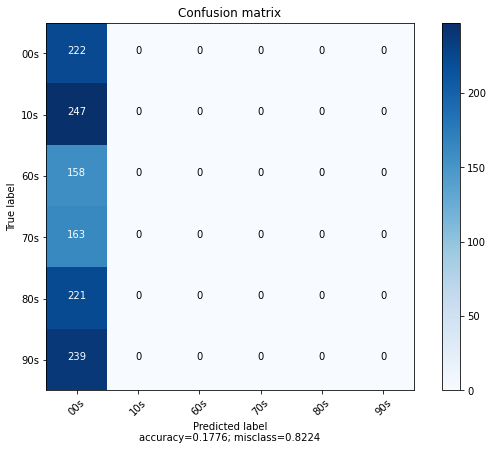

In [12]:
cm = confusion_matrix(y_dev, dumb_predictions_dev)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

### 2nd BASELINE - THE HULK <a name="hulk1"></a>

In [31]:
# FIT BASELINE
lr_base = LogisticRegression(max_iter = 150, solver = "sag", random_state = 1)
lr_base.fit(X_base_train, y_train)

LogisticRegression(max_iter=150, random_state=1, solver='sag')

In [32]:
# TRAIN
pred_base_train = lr_base.predict(X_base_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_base_train))
print("F1 micro:", f1_score(y_train, pred_base_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       0.87      0.85      0.86      1544
         10s       0.87      0.93      0.90      1514
         60s       0.83      0.87      0.85      1024
         70s       0.88      0.83      0.86      1137
         80s       0.87      0.83      0.85      1255
         90s       0.87      0.88      0.88      1526

    accuracy                           0.87      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.87      0.87      0.87      8000

F1 micro: 0.86575


In [33]:
# DEV
pred_base_dev = lr_base.predict(X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_base_dev))
print("F1 micro:", f1_score(y_dev, pred_base_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.38      0.45      0.42       222
         10s       0.56      0.61      0.58       247
         60s       0.48      0.46      0.47       158
         70s       0.30      0.26      0.28       163
         80s       0.34      0.29      0.31       221
         90s       0.44      0.43      0.44       239

    accuracy                           0.43      1250
   macro avg       0.42      0.42      0.42      1250
weighted avg       0.42      0.43      0.42      1250

F1 micro: 0.4272


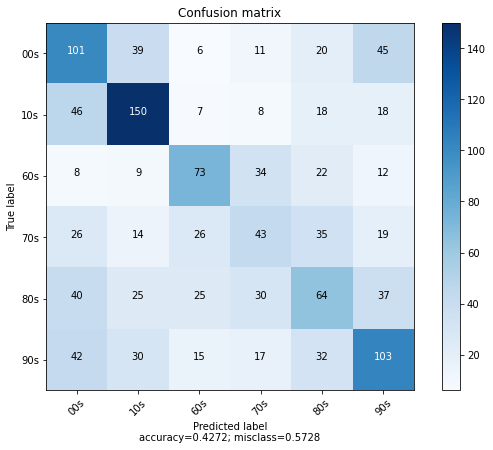

In [18]:
cm = confusion_matrix(y_dev, pred_base_dev)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

Interestingly, the "Hulk" baseline is performing the best on 10s lyrics, which on one hand are among the most recurring, but maybe also the most diverse: for example, edm music is present in this decade only, which may be partially a reason for this.

## BUILDING ON THE BASELINE <a name="build"></a>

Given the good performance of the baseline I firstly decided to try and build on it to improve it. Through a first (here unreported) randomized search cv it emerged the l2 regularization and the balanced class weight overall yielded the best results. So I proceeded exploring the strength of the regularization and the multiclass parameter, and experimented working with a MaxAbsScaler to scale each feature by their maximum absolute value, a preprocessing step specifically intended for sparse matrices. The best performing model on the dev set ended up being the tuned logistic with no scaling, but unfortunately was not able to actually improve upon the baseline.

In [ ]:
base_r_param_v1 = {"C": [0.01,0.1,1, 10, 20],
               "multi_class": ["multinomial", "ovr"]}
grid_base_impr_v1 = RandomizedSearchCV(LogisticRegression(max_iter = 500, solver = "sag", penalty="l2", class_weight ="balanced"),
                                    base_r_param_v1, n_iter = 50, cv = 3, verbose = 5, n_jobs = 1, scoring = "f1_micro")

grid_base_impr_v1.fit(X_base_train, y_train)

In [9]:
print(grid_base_impr_v1.best_estimator_)

Pipeline(steps=[('classifier',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    multi_class='ovr', solver='sag'))])


In [ ]:
# grid_base_impr_v1 = LogisticRegression(C=1, class_weight='balanced', max_iter=500,
#                    multi_class='ovr', solver='sag')
# grid_base_impr_v1.fit(X_base_train, y_train)

### v2 - ADDING THE SCALER

In [19]:
masc = MaxAbsScaler()
Scaled_X_base_train = masc.fit_transform(X_base_train)
Scaled_X_base_dev = masc.transform(X_base_dev)
Scaled_X_base_test = masc.transform(X_base_test)

In [ ]:
base_r_param_v2 = {"C": [0.001,0.01,0.1,1,10],
                 "multi_class": ["ovr", "multinomial"],
                 "class_weight": [None, "balanced"]}

grid_base_impr_v2 = GridSearchCV(LogisticRegression(max_iter = 500, solver = "sag", penalty = "l2", random_state = 1),
                                       base_r_param_v2, cv = 3, scoring = "f1_micro", n_jobs = -1, verbose = 5)
                                      

grid_base_impr_v2.fit(Scaled_X_base_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [15]:
print(grid_base_impr_v2.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=500,
                   multi_class='multinomial', random_state=1, solver='sag')


In [ ]:
# grid_base_impr_v2 = LogisticRegression(C=0.01, class_weight='balanced', max_iter=500,
#                   multi_class='multinomial', random_state=1, solver='sag')
# grid_base_impr_v2.fit(Scaled_X_base_train, y_train)

In [11]:
# TRAINING
pred_base_imp_train = lr_base_impr.predict(Scaled_X_base_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_base_imp_train))
print("F1 micro:", f1_score(y_train, pred_base_imp_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       0.99      0.99      0.99      1544
         10s       1.00      1.00      1.00      1514
         60s       0.99      1.00      1.00      1024
         70s       0.99      1.00      0.99      1137
         80s       0.99      1.00      0.99      1255
         90s       1.00      0.99      0.99      1526

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000

F1 micro: 0.994


In [23]:
# DEV
pred_base_imp_dev = lr_base_impr.predict(Scaled_X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_base_imp_dev))
print("F1 micro:", f1_score(y_dev, pred_base_imp_dev, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       0.34      0.38      0.36       222
         10s       0.59      0.58      0.59       247
         60s       0.48      0.47      0.48       158
         70s       0.29      0.31      0.30       163
         80s       0.34      0.31      0.32       221
         90s       0.42      0.41      0.41       239

    accuracy                           0.42      1250
   macro avg       0.41      0.41      0.41      1250
weighted avg       0.42      0.42      0.42      1250

F1 micro: 0.41520000000000007


## v1 - SVC EXPLORATION <a name="svc"></a>

Secondly, I started looking into Support Vector Machines, exploring with different kernels and hyperparameters through a randomized grid search, introducing some feature selection as well through chi squared correlation, which however didn't seem to lead to improvements in this early phase.

In [17]:
param_grid_svc = {"C": [0.001,0.01,0.1,1,10], "kernel": ["linear", "poly", "rbf"],
                                                     "gamma": ["scale", "auto", 0.001,0.01,0.1,1,10,20]}

grid_svc = RandomizedSearchCV(SVC(),param_grid_svc, n_iter = 10, cv = 3, verbose = 5, scoring = "f1_micro")
grid_svc.fit(X_base_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...C=0.001, gamma=auto, kernel=rbf;, score=0.193 total time= 6.0min
[CV 2/3] END ...C=0.001, gamma=auto, kernel=rbf;, score=0.193 total time= 6.0min
[CV 3/3] END ...C=0.001, gamma=auto, kernel=rbf;, score=0.193 total time= 6.0min
[CV 1/3] END C=0.01, gamma=0.001, kernel=linear;, score=0.193 total time= 5.9min
[CV 2/3] END C=0.01, gamma=0.001, kernel=linear;, score=0.193 total time= 5.9min
[CV 3/3] END C=0.01, gamma=0.001, kernel=linear;, score=0.193 total time= 5.9min
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.193 total time= 6.4min
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.193 total time= 6.3min
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.193 total time= 6.4min
[CV 1/3] END ......C=0.1, gamma=10, kernel=poly;, score=0.293 total time= 6.7min
[CV 2/3] END ......C=0.1, gamma=10, kernel=poly;, score=0.294 total time= 6.7min
[CV 3/3] END ......C=0.1, gamma=10, kernel=poly;

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1, 1, 10, 20],
                                        'kernel': ['linear', 'poly', 'rbf']},
                   scoring='f1_micro', verbose=5)

In [18]:
print(grid_svc.best_estimator_)

SVC(C=10, gamma=0.1, kernel='linear')

In [ ]:
#grid_svc = SVC(C=10, gamma=0.1, kernel='linear')
# grid_svc.fit((X_base_train, y_train)

In [21]:
# TRAINING
pred_svc_grid_train = grid_svc.predict(X_base_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_svc_grid_train))
print("F1 micro:", f1_score(y_train, pred_svc_grid_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       0.99      0.99      0.99      1544
         10s       1.00      1.00      1.00      1514
         60s       1.00      1.00      1.00      1024
         70s       0.99      0.99      0.99      1137
         80s       0.99      0.99      0.99      1255
         90s       0.99      0.99      0.99      1526

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000

F1 micro: 0.99275


In [22]:
# DEV
pred_svc_grid_dev = grid_svc.predict(X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_svc_grid_dev))
print("F1 micro:", f1_score(y_dev, pred_svc_grid_dev, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       0.33      0.42      0.37       222
         10s       0.57      0.53      0.55       247
         60s       0.48      0.46      0.47       158
         70s       0.27      0.29      0.28       163
         80s       0.36      0.30      0.33       221
         90s       0.41      0.39      0.40       239

    accuracy                           0.40      1250
   macro avg       0.40      0.40      0.40      1250
weighted avg       0.41      0.40      0.41      1250

F1 micro: 0.404


## v2 - SVC + FEATURE SELECTION EXPLORATION

In [ ]:
pipe_svc = Pipeline([("selection", SelectKBest(chi2)),
                       ("classifier", SVC())
                   ])

pipe_svc_param = [{"selection__k": [70000,50000,10000,7000,5000],
                    "classifier__C": [0.01,0.1,1,10], "classifier__kernel": ["linear", "rbf"],
                                                     "classifier__gamma": [0.01,0.1,1,10,20]}]

grid_svc_v2 = RandomizedSearchCV(pipe_svc, pipe_svc_param, n_iter = 10, cv = 3, verbose = 5, scoring = "f1_micro")
grid_svc_v2.fit(X_base_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END classifier__C=1, classifier__gamma=20, classifier__kernel=linear, selection__k=7000;, score=0.346 total time= 1.1min
[CV 2/3] END classifier__C=1, classifier__gamma=20, classifier__kernel=linear, selection__k=7000;, score=0.337 total time= 1.0min
[CV 3/3] END classifier__C=1, classifier__gamma=20, classifier__kernel=linear, selection__k=7000;, score=0.331 total time= 1.2min
[CV 1/3] END classifier__C=1, classifier__gamma=0.1, classifier__kernel=rbf, selection__k=70000;, score=0.205 total time= 4.8min
[CV 2/3] END classifier__C=1, classifier__gamma=0.1, classifier__kernel=rbf, selection__k=70000;, score=0.212 total time= 5.2min
[CV 3/3] END classifier__C=1, classifier__gamma=0.1, classifier__kernel=rbf, selection__k=70000;, score=0.222 total time= 5.1min
[CV 1/3] END classifier__C=0.01, classifier__gamma=10, classifier__kernel=linear, selection__k=70000;, score=0.193 total time= 5.2min
[CV 2/3] END classifier__C=0

In [4]:
print(grid_svc_v2.best_estimator_)

Pipeline(steps=[('selection',
                 SelectKBest(k=70000,
                             score_func=<function chi2 at 0x0000022048120820>)),
                ('classifier', SVC(C=10, gamma=10))])


In [13]:
# grid_svc_v2 = Pipeline([("selection", SelectKBest(chi2, k = 70000)),
#                       ("classifier", SVC(C = 10, gamma = 10))
#                   ])
# grid_svc_v2.fit(X_base_train, y_train)

Pipeline(steps=[('selection',
                 SelectKBest(k=70000,
                             score_func=<function chi2 at 0x00000252E59150D0>)),
                ('classifier', SVC(C=10, gamma=10))])

In [14]:
# TRAINING
pred_svc_v2_grid_train = grid_svc_v2.predict(X_base_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_svc_v2_grid_train))
print("F1 micro:", f1_score(y_train, pred_svc_v2_grid_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       1.00      1.00      1.00      1544
         10s       1.00      1.00      1.00      1514
         60s       1.00      1.00      1.00      1024
         70s       1.00      1.00      1.00      1137
         80s       1.00      1.00      1.00      1255
         90s       1.00      1.00      1.00      1526

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

F1 micro: 0.999875


In [15]:
# DEV
pred_svc_v2_grid_dev = grid_svc_v2.predict(X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_svc_v2_grid_dev))
print("F1 micro:", f1_score(y_dev, pred_svc_v2_grid_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.18      0.92      0.30       222
         10s       0.25      0.04      0.07       247
         60s       0.64      0.06      0.10       158
         70s       0.62      0.09      0.16       163
         80s       0.62      0.07      0.12       221
         90s       0.44      0.05      0.09       239

    accuracy                           0.21      1250
   macro avg       0.46      0.20      0.14      1250
weighted avg       0.44      0.21      0.14      1250

F1 micro: 0.212


## v3 - LINEAR KERNEL SVC FINE TUNING

From the exploration phase it emerged that the linear kernel was performing considerably well, therefore I decided to tune more carefully its regularization parameter running a grid search with the faster LinearSVC function and increasing to a 5 fold cross validation. Indeed this reached a better performing model on the dev set, both in terms of f1 score and accuracy. 

In [9]:
param_grid_svc_v3 = {"C": [0.001,0.01,0.1,1,10]}

grid_svc_v3 = GridSearchCV(LinearSVC(),param_grid_svc_v3, cv = 5, verbose = 5, scoring = "f1_micro")
grid_svc_v3.fit(X_base_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.247 total time=   4.3s
[CV 2/5] END ...........................C=0.001;, score=0.239 total time=   3.2s
[CV 3/5] END ...........................C=0.001;, score=0.253 total time=   4.1s
[CV 4/5] END ...........................C=0.001;, score=0.251 total time=   3.3s
[CV 5/5] END ...........................C=0.001;, score=0.240 total time=   3.8s
[CV 1/5] END ............................C=0.01;, score=0.338 total time=   4.9s
[CV 2/5] END ............................C=0.01;, score=0.361 total time=   5.1s
[CV 3/5] END ............................C=0.01;, score=0.344 total time=   5.1s
[CV 4/5] END ............................C=0.01;, score=0.349 total time=   4.7s
[CV 5/5] END ............................C=0.01;, score=0.344 total time=   4.7s
[CV 1/5] END .............................C=0.1;, score=0.417 total time=   6.4s
[CV 2/5] END .............................C=0.1;,

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, scoring='f1_micro',
             verbose=5)

In [10]:
print(grid_svc_v3.best_estimator_)

LinearSVC(C=0.1)


In [16]:
# further tuning
param_grid_svc_v32 = {"C": np.linspace(0.02,0.8,15)}

grid_svc_v32 = GridSearchCV(LinearSVC(),param_grid_svc_v32, cv = 5, verbose = 5, scoring = "f1_micro")
grid_svc_v32.fit(X_base_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ............................C=0.02;, score=0.383 total time=   4.6s
[CV 2/5] END ............................C=0.02;, score=0.398 total time=   4.8s
[CV 3/5] END ............................C=0.02;, score=0.379 total time=   4.6s
[CV 4/5] END ............................C=0.02;, score=0.375 total time=   5.4s
[CV 5/5] END ............................C=0.02;, score=0.381 total time=   4.5s
[CV 1/5] END .............C=0.07571428571428572;, score=0.414 total time=   5.5s
[CV 2/5] END .............C=0.07571428571428572;, score=0.417 total time=   5.7s
[CV 3/5] END .............C=0.07571428571428572;, score=0.419 total time=   5.9s
[CV 4/5] END .............C=0.07571428571428572;, score=0.406 total time=   5.2s
[CV 5/5] END .............C=0.07571428571428572;, score=0.404 total time=   5.8s
[CV 1/5] END .............C=0.13142857142857142;, score=0.421 total time=   6.2s
[CV 2/5] END .............C=0.13142857142857142;

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': array([0.02      , 0.07571429, 0.13142857, 0.18714286, 0.24285714,
       0.29857143, 0.35428571, 0.41      , 0.46571429, 0.52142857,
       0.57714286, 0.63285714, 0.68857143, 0.74428571, 0.8       ])},
             scoring='f1_micro', verbose=5)

In [17]:
print(grid_svc_v32.best_estimator_)

LinearSVC(C=0.18714285714285714)


In [10]:
#grid_svc_v32 = LinearSVC(C=0.18714285714285714)
#grid_svc_v32.fit(X_base_train, y_train)

LinearSVC(C=0.18714285714285714)

In [18]:
# TRAINING
pred_svc_v32_grid_train = grid_svc_v32.predict(X_base_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_svc_v32_grid_train))
print("F1 micro:", f1_score(y_train, pred_svc_v32_grid_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       0.94      0.90      0.92      1544
         10s       0.93      0.96      0.94      1514
         60s       0.90      0.96      0.93      1024
         70s       0.95      0.93      0.94      1137
         80s       0.94      0.91      0.93      1255
         90s       0.94      0.92      0.93      1526

    accuracy                           0.93      8000
   macro avg       0.93      0.93      0.93      8000
weighted avg       0.93      0.93      0.93      8000

F1 micro: 0.931125


In [24]:
# DEV
pred_svc_v32_grid_dev = grid_svc_v32.predict(X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_svc_v32_grid_dev))
print("F1 micro:", f1_score(y_dev, pred_svc_v32_grid_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.39      0.42      0.40       222
         10s       0.55      0.66      0.60       247
         60s       0.48      0.54      0.51       158
         70s       0.32      0.28      0.30       163
         80s       0.36      0.27      0.31       221
         90s       0.45      0.42      0.43       239

    accuracy                           0.44      1250
   macro avg       0.42      0.43      0.42      1250
weighted avg       0.43      0.44      0.43      1250

F1 micro: 0.4368000000000001


Given the speed of the algorithm was noticeably higher than its broader SVC counterpart, I decided to also consider more hyperparameters and the feature selection in one same pipeline, although the best performing results mostly seem to be obtained keeping all of the features.

In [11]:
X_base_train.shape

(8000, 149482)

In [16]:
pipe_svc_v4 = Pipeline([("selection", SelectKBest(chi2)),
                       ("classifier", LinearSVC())
                   ])

pipe_svc_param_v4 = [{"selection__k": [120000, 100000, 70000,50000,30000,10000,5000],
                    "classifier__C": [0.01,0.1,1,10], "classifier__class_weight": [None, "balanced"]}]

grid_svc_v4 = GridSearchCV(pipe_svc_v4, pipe_svc_param_v4, cv = 5, verbose = 5, scoring = "f1_micro")
grid_svc_v4.fit(X_base_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=120000;, score=0.338 total time=   5.0s
[CV 2/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=120000;, score=0.371 total time=   4.3s
[CV 3/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=120000;, score=0.349 total time=   5.0s
[CV 4/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=120000;, score=0.349 total time=   5.0s
[CV 5/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=120000;, score=0.348 total time=   4.3s
[CV 1/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=100000;, score=0.336 total time=   3.8s
[CV 2/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=100000;, score=0.367 total time=   3.8s
[CV 3/5] END classifier__C=0.01, classifier__class_weight=None, selection__k=100000;, score=0.352 total time=   4.1s
[C

[CV 5/5] END classifier__C=0.01, classifier__class_weight=balanced, selection__k=5000;, score=0.339 total time=   1.4s
[CV 1/5] END classifier__C=0.1, classifier__class_weight=None, selection__k=120000;, score=0.412 total time=   6.8s
[CV 2/5] END classifier__C=0.1, classifier__class_weight=None, selection__k=120000;, score=0.425 total time=   6.4s
[CV 3/5] END classifier__C=0.1, classifier__class_weight=None, selection__k=120000;, score=0.424 total time=   6.9s
[CV 4/5] END classifier__C=0.1, classifier__class_weight=None, selection__k=120000;, score=0.415 total time=   6.3s
[CV 5/5] END classifier__C=0.1, classifier__class_weight=None, selection__k=120000;, score=0.407 total time=   6.2s
[CV 1/5] END classifier__C=0.1, classifier__class_weight=None, selection__k=100000;, score=0.406 total time=   5.5s
[CV 2/5] END classifier__C=0.1, classifier__class_weight=None, selection__k=100000;, score=0.422 total time=   4.2s
[CV 3/5] END classifier__C=0.1, classifier__class_weight=None, select

[CV 5/5] END classifier__C=0.1, classifier__class_weight=balanced, selection__k=5000;, score=0.354 total time=   1.3s
[CV 1/5] END classifier__C=1, classifier__class_weight=None, selection__k=120000;, score=0.400 total time=  12.7s
[CV 2/5] END classifier__C=1, classifier__class_weight=None, selection__k=120000;, score=0.426 total time=  12.2s
[CV 3/5] END classifier__C=1, classifier__class_weight=None, selection__k=120000;, score=0.406 total time=  12.7s
[CV 4/5] END classifier__C=1, classifier__class_weight=None, selection__k=120000;, score=0.409 total time=  12.4s
[CV 5/5] END classifier__C=1, classifier__class_weight=None, selection__k=120000;, score=0.397 total time=  14.6s
[CV 1/5] END classifier__C=1, classifier__class_weight=None, selection__k=100000;, score=0.399 total time=  12.3s
[CV 2/5] END classifier__C=1, classifier__class_weight=None, selection__k=100000;, score=0.420 total time=  11.9s
[CV 3/5] END classifier__C=1, classifier__class_weight=None, selection__k=100000;, s

[CV 2/5] END classifier__C=10, classifier__class_weight=None, selection__k=120000;, score=0.399 total time= 1.3min
[CV 3/5] END classifier__C=10, classifier__class_weight=None, selection__k=120000;, score=0.378 total time= 1.3min
[CV 4/5] END classifier__C=10, classifier__class_weight=None, selection__k=120000;, score=0.385 total time= 1.3min
[CV 5/5] END classifier__C=10, classifier__class_weight=None, selection__k=120000;, score=0.385 total time= 1.3min
[CV 1/5] END classifier__C=10, classifier__class_weight=None, selection__k=100000;, score=0.381 total time= 1.0min
[CV 2/5] END classifier__C=10, classifier__class_weight=None, selection__k=100000;, score=0.391 total time= 1.1min
[CV 3/5] END classifier__C=10, classifier__class_weight=None, selection__k=100000;, score=0.378 total time= 1.1min
[CV 4/5] END classifier__C=10, classifier__class_weight=None, selection__k=100000;, score=0.383 total time= 1.0min
[CV 5/5] END classifier__C=10, classifier__class_weight=None, selection__k=10000

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selection',
                                        SelectKBest(score_func=<function chi2 at 0x00000252E59150D0>)),
                                       ('classifier', LinearSVC())]),
             param_grid=[{'classifier__C': [0.01, 0.1, 1, 10],
                          'classifier__class_weight': [None, 'balanced'],
                          'selection__k': [120000, 100000, 70000, 50000, 30000,
                                           10000, 5000]}],
             scoring='f1_micro', verbose=5)

In [17]:
print(grid_svc_v4.best_estimator_)

Pipeline(steps=[('selection',
                 SelectKBest(k=120000,
                             score_func=<function chi2 at 0x00000252E59150D0>)),
                ('classifier', LinearSVC(C=0.1))])


In [ ]:
# grid_svc_v4 = Pipeline([("selection", SelectKBest(chi2, k = 120000)),
#                        ("classifier", LinearSVC(C 0.1))
#                    ])

# grid_svc_v4.fit(X_base_train, y_train)

In [18]:
# TRAINING
pred_svc_v4_pipe_train = grid_svc_v4.predict(X_base_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_svc_v4_pipe_train))
print("F1 micro:", f1_score(y_train, pred_svc_v4_pipe_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       0.86      0.81      0.83      1544
         10s       0.82      0.92      0.87      1514
         60s       0.80      0.88      0.84      1024
         70s       0.87      0.82      0.84      1137
         80s       0.87      0.80      0.84      1255
         90s       0.86      0.84      0.85      1526

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.84      8000
weighted avg       0.85      0.85      0.85      8000

F1 micro: 0.845375


In [19]:
# DEV
pred_svc_v4_pipe_dev = grid_svc_v4.predict(X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_svc_v4_pipe_dev))
print("F1 micro:", f1_score(y_dev, pred_svc_v4_pipe_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.41      0.44      0.42       222
         10s       0.54      0.65      0.59       247
         60s       0.46      0.54      0.50       158
         70s       0.32      0.26      0.29       163
         80s       0.34      0.27      0.30       221
         90s       0.45      0.42      0.43       239

    accuracy                           0.44      1250
   macro avg       0.42      0.43      0.42      1250
weighted avg       0.43      0.44      0.43      1250

F1 micro: 0.4368000000000001


Finally, I calibrated the probabilities of the best performing SVCs through CalibratedClassifierCV.

In [12]:
calibrated_svm = CalibratedClassifierCV(grid_svc_v32, cv = "prefit")
calibrated_svm.fit(X_base_dev, y_dev)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.18714285714285714),
                       cv='prefit')

In [58]:
# DEV
pred_calibrated_svc_dev = calibrated_svm.predict(X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_calibrated_svc_dev))
print("F1 micro:", f1_score(y_dev, pred_calibrated_svc_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.41      0.36      0.38       222
         10s       0.55      0.68      0.61       247
         60s       0.50      0.54      0.52       158
         70s       0.33      0.25      0.28       163
         80s       0.31      0.32      0.32       221
         90s       0.45      0.43      0.44       239

    accuracy                           0.44      1250
   macro avg       0.42      0.43      0.42      1250
weighted avg       0.43      0.44      0.43      1250

F1 micro: 0.4376


In [25]:
calibrated_svm_v4 = CalibratedClassifierCV(grid_svc_v4, cv = "prefit")
calibrated_svm_v4.fit(X_base_dev, y_dev)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5,
                                                   estimator=Pipeline(steps=[('selection',
                                                                              SelectKBest(score_func=<function chi2 at 0x00000252E59150D0>)),
                                                                             ('classifier',
                                                                              LinearSVC())]),
                                                   param_grid=[{'classifier__C': [0.01,
                                                                                  0.1,
                                                                                  1,
                                                                                  10],
                                                                'classifier__class_weight': [None,
                                                                              

In [26]:
# DEV
pred_calibrated_svc_v4_dev = calibrated_svm_v4.predict(X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_calibrated_svc_v4_dev))
print("F1 micro:", f1_score(y_dev, pred_calibrated_svc_v4_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.42      0.31      0.36       222
         10s       0.54      0.70      0.61       247
         60s       0.47      0.52      0.49       158
         70s       0.32      0.25      0.28       163
         80s       0.32      0.33      0.33       221
         90s       0.43      0.41      0.42       239

    accuracy                           0.43      1250
   macro avg       0.42      0.42      0.41      1250
weighted avg       0.42      0.43      0.42      1250

F1 micro: 0.42960000000000004


Finally, the calibrated and tune SVC with no feature selection was the best performing modelon the dev set.

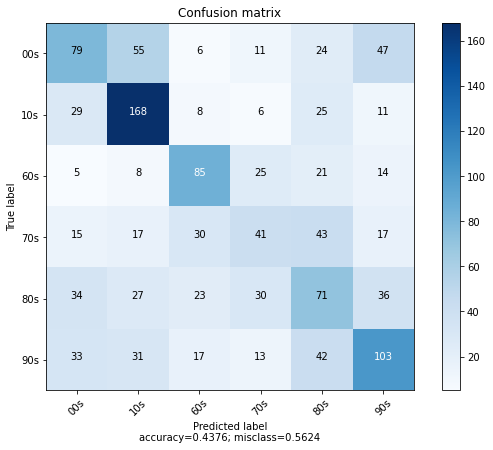

In [46]:
cm = confusion_matrix(y_dev, pred_calibrated_svc_dev)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

## SVC - CONCLUSIONS

Although the difference is not too impressive, this fine tuned and calibrated support vector classifier indeed outperforms the "Hulk" baseline on development set. The performance of all models on the test set will be reported in the summary section. Best model is reported below.

In [14]:
# grid_svc_v32 = LinearSVC(C=0.18714285714285714)
# grid_svc_v32.fit(X_base_train, y_train)

# calibrated_svm = CalibratedClassifierCV(grid_svc_v32, cv = "prefit")
# calibrated_svm.fit(X_base_dev, y_dev)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.18714285714285714),
                       cv='prefit')

## v1 - RANDOM FOREST <a name="rf"></a>

Thirdly, I used a TFIDF vectorizer for words (unigrams, bigrams), and ran a simple random forest without any hyperparameters tuning. This was generating a excessively high f1 and accuracy scores: all labels were correctly predicted. Again, this was suggesting there might have been some overfitting problems, which was confirmed by the considerably lower dev accuracy score.

In [19]:
# DESIGN MATRICES
ngram_range = (1,2)
min_df = 0.001
max_df = 0.7
analyzer = "word"

tfidf_vectorizer_rf = TfidfVectorizer(analyzer= analyzer,
                                   ngram_range= ngram_range, 
                                   min_df = min_df, 
                                   max_df = max_df, 
                                   stop_words= 'english', 
                                   sublinear_tf=True,
                                   use_idf=True)

X_rf_train = tfidf_vectorizer_rf.fit_transform(tokens_train)
X_rf_dev = tfidf_vectorizer_rf.transform(tokens_dev)
X_rf_test = tfidf_vectorizer_rf.transform(tokens_test)

In [7]:
# RANDOM FOREST
rf = RandomForestClassifier(n_estimators = 100, max_features = "sqrt", random_state = 42)
rf.fit(X_rf_train, y_train)

RandomForestClassifier(max_features='sqrt', random_state=42)

In [8]:
# TRAINING
pred_rf_v1_train = rf.predict(X_rf_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_rf_v1_train))
print("F1 micro:", f1_score(y_train, pred_rf_v1_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       1.00      1.00      1.00      1544
         10s       1.00      1.00      1.00      1514
         60s       1.00      1.00      1.00      1024
         70s       1.00      1.00      1.00      1137
         80s       1.00      1.00      1.00      1255
         90s       1.00      1.00      1.00      1526

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [9]:
# DEV
pred_rf_v1_dev = rf.predict(X_rf_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_rf_v1_dev))
print("F1 micro:", f1_score(y_dev, pred_rf_v1_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.35      0.36      0.36       222
         10s       0.44      0.63      0.52       247
         60s       0.41      0.51      0.46       158
         70s       0.29      0.27      0.28       163
         80s       0.33      0.19      0.24       221
         90s       0.37      0.29      0.32       239

    accuracy                           0.38      1250
   macro avg       0.36      0.38      0.36      1250
weighted avg       0.37      0.38      0.37      1250



## v2 - RANDOM FOREST + HYPER PARAMETERS TUNING

To try and account for the overfitting risk some hyperparameter tuning was performed, again starting with a randomized search and following with a grid search in the neighborhood of the best performing parameters, which indeed allowed to reach results comparable to the baseline on the dev set, but still falling right behind it.

In [10]:
r_grid_param = {"n_estimators": [100, 500, 1000],
                "max_features": ["sqrt"],
                "criterion" :["gini", "entropy"],
                "max_depth": [100, 200, 500,1000],
                "min_samples_leaf": [2,4,8,20,50],
                "min_samples_split": [2, 4,8,20,50]}

grid_rf_v2 = RandomizedSearchCV(RandomForestClassifier(random_state = 42), n_iter = 50, param_distributions = r_grid_param,
                                cv = 3, verbose = 5, scoring = "f1_micro")

grid_rf_v2.fit(X_rf_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END criterion=entropy, max_depth=500, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=500;, score=0.347 total time=   9.7s
[CV 2/3] END criterion=entropy, max_depth=500, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=500;, score=0.336 total time=   8.3s
[CV 3/3] END criterion=entropy, max_depth=500, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=500;, score=0.343 total time=   8.3s
[CV 1/3] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=100;, score=0.362 total time=   7.0s
[CV 2/3] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=100;, score=0.359 total time=   6.8s
[CV 3/3] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=100;, score=0.367 total 

[CV 2/3] END criterion=gini, max_depth=200, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=1000;, score=0.388 total time=  46.1s
[CV 3/3] END criterion=gini, max_depth=200, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=1000;, score=0.392 total time=  47.0s
[CV 1/3] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=1000;, score=0.403 total time=  55.6s
[CV 2/3] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=1000;, score=0.389 total time=  56.4s
[CV 3/3] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=1000;, score=0.387 total time=  56.7s
[CV 1/3] END criterion=gini, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000;, score=0.404 total time= 1.3min
[CV 2/3] END criterion=gini, max_depth=500, max_features=sqrt, mi

[CV 1/3] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1000;, score=0.380 total time=  36.4s
[CV 2/3] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1000;, score=0.368 total time=  34.7s
[CV 3/3] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1000;, score=0.365 total time=  35.2s
[CV 1/3] END criterion=entropy, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.374 total time=   8.6s
[CV 2/3] END criterion=entropy, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.360 total time=   9.0s
[CV 3/3] END criterion=entropy, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.369 total time=   9.8s
[CV 1/3] END criterion=gini, max_depth=100, max_feat

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [100, 200, 500, 1000],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4, 8, 20, 50],
                                        'min_samples_split': [2, 4, 8, 20, 50],
                                        'n_estimators': [100, 500, 1000]},
                   scoring='f1_micro', verbose=5)

In [6]:
print(grid_rf_v2.best_estimator_)

RandomForestClassifier(max_depth=500, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=500, random_state=42)

In [ ]:
# grid_rf_v2 = RandomForestClassifier(max_depth=500, max_features='sqrt', min_samples_leaf=2,
#                       min_samples_split=4, n_estimators=500, random_state=42)
#grid_rf_v2.fit(X_rf_train, y_train)

In [7]:
# TRAINING
pred_rf_v2_train = grid_rf_v2.predict(X_rf_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_rf_v2_train))
print("F1 micro:", f1_score(y_train, pred_rf_v2_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       1.00      0.99      1.00      1544
         10s       0.99      1.00      0.99      1514
         60s       0.98      0.99      0.99      1024
         70s       1.00      0.99      0.99      1137
         80s       1.00      1.00      1.00      1255
         90s       1.00      0.99      1.00      1526

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000

F1 micro: 0.993625


In [8]:
# DEV
pred_rf_v2_dev = grid_rf_v2.predict(X_rf_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_rf_v2_dev))
print("F1 micro:", f1_score(y_dev, pred_rf_v2_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.42      0.46      0.44       222
         10s       0.50      0.68      0.58       247
         60s       0.46      0.49      0.47       158
         70s       0.30      0.28      0.29       163
         80s       0.36      0.29      0.32       221
         90s       0.41      0.30      0.34       239

    accuracy                           0.42      1250
   macro avg       0.41      0.42      0.41      1250
weighted avg       0.41      0.42      0.41      1250

F1 micro: 0.4232


## v3 - TUNED RF ADDING A FEATURE SELECTION STEP

Although results are slightly better, there is a very strong difference between the training and the development results, and as half of the times in machine learning, the problem is overfitting. One other way to counteract this issue is to limit the number of features, hence introduce some feature selection procedure, which, however, yet again failed to yield improvements.

In [10]:
X_rf_train.shape

(8000, 11687)

In [11]:
pipe_rf_v3 = Pipeline([("selection", SelectKBest(chi2)),
                  ("classifier", RandomForestClassifier(random_state = 42,max_features= "sqrt", n_estimators = 500))
                   ])

pipe_rf_v3_grid = [{
    "selection__k": [10000, 7000, 5000, 3000, 1000],
    "classifier__max_depth": [100, 200, 500, 800],
    "classifier__min_samples_leaf": [2,4,8,20,50],
    "classifier__min_samples_leaf": [2,4,8,20,50]
    
}]

grid_rf_v3 = RandomizedSearchCV(pipe_rf_v3, pipe_rf_v3_grid, n_iter = 100, scoring = "f1_micro", verbose = 5, cv = 3)
grid_rf_v3.fit(X_rf_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, selection__k=10000;, score=0.393 total time=  15.3s
[CV 2/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, selection__k=10000;, score=0.391 total time=  11.5s
[CV 3/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, selection__k=10000;, score=0.372 total time=  13.6s
[CV 1/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, selection__k=7000;, score=0.394 total time=  13.0s
[CV 2/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, selection__k=7000;, score=0.388 total time=   9.9s
[CV 3/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, selection__k=7000;, score=0.390 total time=  10.6s
[CV 1/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, selection__k=5000;, score=0.394 total time=  10.1s
[CV 2/3] END classifier__max_depth=100, classifier__min_samples_leaf=2, s

[CV 1/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=5000;, score=0.301 total time=   4.3s
[CV 2/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=5000;, score=0.291 total time=   3.9s
[CV 3/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=5000;, score=0.292 total time=   4.2s
[CV 1/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=3000;, score=0.315 total time=   4.3s
[CV 2/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=3000;, score=0.289 total time=   3.8s
[CV 3/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=3000;, score=0.301 total time=   4.3s
[CV 1/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=1000;, score=0.298 total time=   3.6s
[CV 2/3] END classifier__max_depth=100, classifier__min_samples_leaf=50, selection__k=1000;, score=0.288 total time=   3.8s
[CV 3/3]

[CV 2/3] END classifier__max_depth=200, classifier__min_samples_leaf=20, selection__k=1000;, score=0.322 total time=   5.5s
[CV 3/3] END classifier__max_depth=200, classifier__min_samples_leaf=20, selection__k=1000;, score=0.331 total time=   5.2s
[CV 1/3] END classifier__max_depth=200, classifier__min_samples_leaf=50, selection__k=10000;, score=0.290 total time=   4.8s
[CV 2/3] END classifier__max_depth=200, classifier__min_samples_leaf=50, selection__k=10000;, score=0.288 total time=   4.9s
[CV 3/3] END classifier__max_depth=200, classifier__min_samples_leaf=50, selection__k=10000;, score=0.270 total time=   4.6s
[CV 1/3] END classifier__max_depth=200, classifier__min_samples_leaf=50, selection__k=7000;, score=0.291 total time=   4.5s
[CV 2/3] END classifier__max_depth=200, classifier__min_samples_leaf=50, selection__k=7000;, score=0.284 total time=   4.4s
[CV 3/3] END classifier__max_depth=200, classifier__min_samples_leaf=50, selection__k=7000;, score=0.281 total time=   4.6s
[CV 1

[CV 3/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=7000;, score=0.331 total time=   6.1s
[CV 1/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=5000;, score=0.354 total time=   6.5s
[CV 2/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=5000;, score=0.328 total time=   5.7s
[CV 3/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=5000;, score=0.342 total time=   6.4s
[CV 1/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=3000;, score=0.357 total time=   6.2s
[CV 2/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=3000;, score=0.340 total time=   5.9s
[CV 3/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=3000;, score=0.335 total time=   5.6s
[CV 1/3] END classifier__max_depth=500, classifier__min_samples_leaf=20, selection__k=1000;, score=0.333 total time=   4.6s
[CV 2/3]

[CV 1/3] END classifier__max_depth=800, classifier__min_samples_leaf=8, selection__k=1000;, score=0.357 total time=   7.3s
[CV 2/3] END classifier__max_depth=800, classifier__min_samples_leaf=8, selection__k=1000;, score=0.337 total time=   7.8s
[CV 3/3] END classifier__max_depth=800, classifier__min_samples_leaf=8, selection__k=1000;, score=0.345 total time=   7.9s
[CV 1/3] END classifier__max_depth=800, classifier__min_samples_leaf=20, selection__k=10000;, score=0.351 total time=   7.0s
[CV 2/3] END classifier__max_depth=800, classifier__min_samples_leaf=20, selection__k=10000;, score=0.339 total time=   7.2s
[CV 3/3] END classifier__max_depth=800, classifier__min_samples_leaf=20, selection__k=10000;, score=0.338 total time=   7.2s
[CV 1/3] END classifier__max_depth=800, classifier__min_samples_leaf=20, selection__k=7000;, score=0.349 total time=   6.6s
[CV 2/3] END classifier__max_depth=800, classifier__min_samples_leaf=20, selection__k=7000;, score=0.334 total time=   6.4s
[CV 3/3]

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('selection',
                                              SelectKBest(score_func=<function chi2 at 0x00000217E9437D30>)),
                                             ('classifier',
                                              RandomForestClassifier(max_features='sqrt',
                                                                     n_estimators=500,
                                                                     random_state=42))]),
                   n_iter=100,
                   param_distributions=[{'classifier__max_depth': [100, 200,
                                                                   500, 800],
                                         'classifier__min_samples_leaf': [2, 4,
                                                                          8, 20,
                                                                          50],
                                         'selection__

In [16]:
print(grid_rf_v3.best_estimator_)

Pipeline(steps=[('selection',
                 SelectKBest(k=7000,
                             score_func=<function chi2 at 0x00000217E9437D30>)),
                ('classifier',
                 RandomForestClassifier(max_depth=100, max_features='sqrt',
                                        min_samples_leaf=2, n_estimators=500,
                                        random_state=42))])


In [ ]:
#grid_rf_v3 = Pipeline([("selection", SelectKBest(chi2, k = 7000)),
#                  ("classifier", RandomForestClassifier(max_depth=100, max_features='sqrt',
#                                         min_samples_leaf=2, n_estimators=500,
#                                         random_state=42))
#                   ])
# grid_rf_v3.fit(X_rf_train, y_train)

In [13]:
# TRAINING
pred_rf_v3_train = grid_rf_v3.predict(X_rf_train)
print("Training - Classification Report:")
print()
print(classification_report(y_train, pred_rf_v3_train))
print("F1 micro:", f1_score(y_train, pred_rf_v3_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

         00s       1.00      0.98      0.99      1544
         10s       0.98      0.99      0.99      1514
         60s       0.96      0.99      0.97      1024
         70s       1.00      0.98      0.99      1137
         80s       0.99      0.99      0.99      1255
         90s       1.00      0.99      0.99      1526

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000

F1 micro: 0.98925


In [14]:
# DEV
pred_rf_v3_dev = grid_rf_v3.predict(X_rf_dev)
print("Dev - Classification Report:")
print()
print(classification_report(y_dev, pred_rf_v3_dev))
print("F1 micro:", f1_score(y_dev, pred_rf_v3_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

         00s       0.42      0.45      0.43       222
         10s       0.53      0.66      0.59       247
         60s       0.48      0.51      0.50       158
         70s       0.34      0.34      0.34       163
         80s       0.40      0.34      0.37       221
         90s       0.41      0.32      0.36       239

    accuracy                           0.44      1250
   macro avg       0.43      0.44      0.43      1250
weighted avg       0.43      0.44      0.43      1250

F1 micro: 0.4408


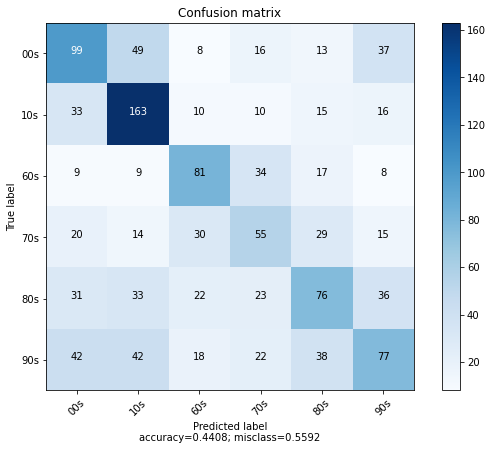

In [45]:
cm = confusion_matrix(y_dev, pred_rf_v3_dev)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

## RANDOM FOREST - CONCLUSIONS

This seemed like a good result and it didn't look like further tuning could improve the model even more, so I proceeded to evaluate the test performance of the two obtained models. Best model is reported below.

In [20]:
# grid_rf_v3 = Pipeline([("selection", SelectKBest(chi2, k = 7000)),
#                   ("classifier", RandomForestClassifier(max_depth=100, max_features='sqrt',
#                                          min_samples_leaf=2, n_estimators=500,
#                                          random_state=42))
#                    ])

# grid_rf_v3.fit(X_rf_train, y_train)

Pipeline(steps=[('selection',
                 SelectKBest(k=7000,
                             score_func=<function chi2 at 0x00000274C3B46D30>)),
                ('classifier',
                 RandomForestClassifier(max_depth=100, max_features='sqrt',
                                        min_samples_leaf=2, n_estimators=500,
                                        random_state=42))])

## TEST PERFORMANCE AND SUMMARY <a name="test"></a>

 We can finally predict the test observations and compare the 2 models with the baselines. Firstly, the testing classification reports will be shown, then bootstrap sampling will be carried out to see significance of results.

### 1st BASELINE - MOST FREQUENT PREDICTOR

In [29]:
# TEST
dumb_predictions_test = most_frequent.predict(X_base_test)

print("Test - Classification Report")
print(classification_report(y_test, dumb_predictions_test))
print("F1 micro:", f1_score(y_test, dumb_predictions_test, average = "micro"))

Test - Classification Report
              precision    recall  f1-score   support

         00s       0.19      1.00      0.32       234
         10s       0.00      0.00      0.00       239
         60s       0.00      0.00      0.00       133
         70s       0.00      0.00      0.00       186
         80s       0.00      0.00      0.00       182
         90s       0.00      0.00      0.00       235

    accuracy                           0.19      1209
   macro avg       0.03      0.17      0.05      1209
weighted avg       0.04      0.19      0.06      1209

F1 micro: 0.1935483870967742


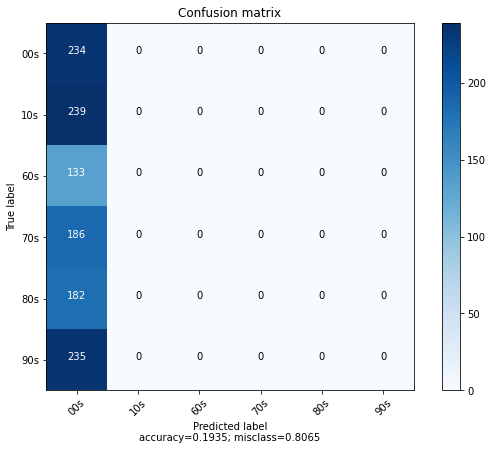

In [47]:
cm = confusion_matrix(y_test, dumb_predictions_test)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

### 2nd BASELINE - THE HULK

In [36]:
# TEST
pred_base_test = lr_base.predict(X_base_test)
print("Testing - Classification Report:")
print()
print(classification_report(y_test, pred_base_test))
print("F1 micro:", f1_score(y_test, pred_base_test, average = "micro"))

Testing - Classification Report:

              precision    recall  f1-score   support

         00s       0.37      0.39      0.38       234
         10s       0.51      0.59      0.54       239
         60s       0.43      0.47      0.45       133
         70s       0.43      0.34      0.38       186
         80s       0.32      0.27      0.29       182
         90s       0.39      0.38      0.38       235

    accuracy                           0.41      1209
   macro avg       0.41      0.41      0.41      1209
weighted avg       0.41      0.41      0.41      1209

F1 micro: 0.41191066997518605


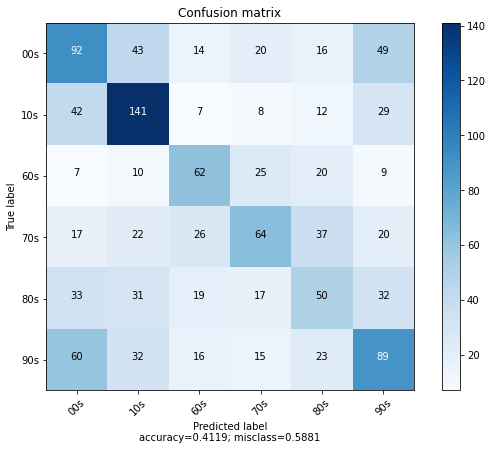

In [48]:
cm = confusion_matrix(y_test, pred_base_test)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

### CALIBRATED AND REGULARIZED LINEAR SVC

In [64]:
# TEST
pred_calibrated_svc_test = calibrated_svm.predict(X_base_test)
print("Test - Classification Report:")
print()
print(classification_report(y_test, pred_calibrated_svc_test))
print("F1 micro:", f1_score(y_test, pred_calibrated_svc_test, average = "micro"))

Test - Classification Report:

              precision    recall  f1-score   support

         00s       0.41      0.32      0.36       234
         10s       0.50      0.67      0.58       239
         60s       0.41      0.52      0.46       133
         70s       0.42      0.28      0.34       186
         80s       0.32      0.34      0.33       182
         90s       0.43      0.41      0.42       235

    accuracy                           0.43      1209
   macro avg       0.42      0.42      0.41      1209
weighted avg       0.42      0.43      0.42      1209

F1 micro: 0.4251447477253929


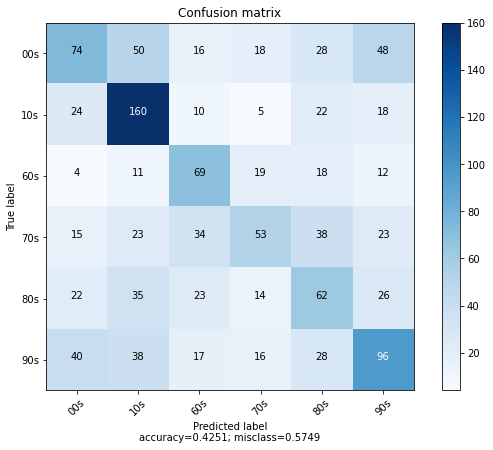

In [49]:
cm = confusion_matrix(y_test, pred_calibrated_svc_test)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

The SVC indeed has a F1 score micro higher than both baselines. Through bootstrap sampling we can see the statistical significance of the results, and it turns out the model is outperforming both baselines with a confidence level of 5%. 

In [33]:
# MOST FREQUENT PREDICTOR
p_value, deltas = bootstrap_sample(pred_calibrated_svc_test, dumb_predictions_test, y_test, average = "micro")
print(p_value, p_value < 0.05)

Base difference: 0.4251447477253929 vs. 0.1935483870967742
0.0 True


In [63]:
# HULK
p_value, deltas = bootstrap_sample(pred_calibrated_svc_test, pred_base_test, y_test, average = "micro")
print(p_value, p_value < 0.05)

Base difference: 0.4251447477253929 vs. 0.41191066997518605
0.048 True


### TUNED RANDOM FOREST

Surprisingly, the model yielded far worse results on the testing set, implying it was not able to beat the Hulk baseline.

In [22]:
# TEST
pred_rf_v3_test = grid_rf_v3.predict(X_rf_test)
print("Test - Classification Report:")
print()
print(classification_report(y_test, pred_rf_v3_test))
print("F1 micro:", f1_score(y_test, pred_rf_v3_test, average = "micro"))

Test - Classification Report:

              precision    recall  f1-score   support

         00s       0.35      0.38      0.36       234
         10s       0.48      0.62      0.54       239
         60s       0.36      0.43      0.39       133
         70s       0.38      0.29      0.33       186
         80s       0.27      0.28      0.28       182
         90s       0.44      0.30      0.36       235

    accuracy                           0.39      1209
   macro avg       0.38      0.38      0.37      1209
weighted avg       0.39      0.39      0.38      1209

F1 micro: 0.3862696443341604


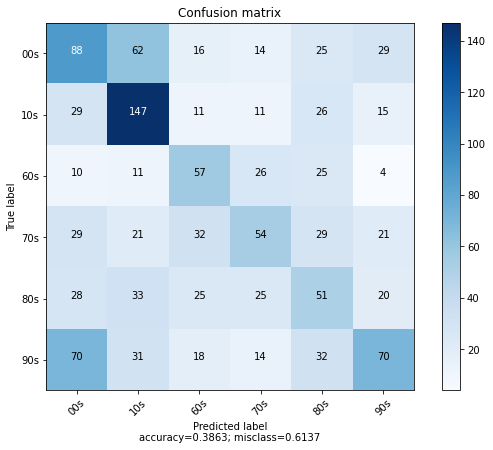

In [50]:
cm = confusion_matrix(y_test, pred_rf_v3_test)

plot_confusion_matrix(cm = cm, target_names = ["00s", "10s", "60s", "70s", "80s", "90s"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

On the other hand, the random forest model still outperforms the most frequent predictor baseline.

In [32]:
pvalue, delta = bootstrap_sample(pred_rf_v3_test, dumb_predictions_test, y_test)
print(pvalue, pvalue < 0.05)

Base difference: 0.3862696443341604 vs. 0.1935483870967742
0.0 True


Interestingly, the 10s label is always the most correctly predicted on the test set, which could indeed mean that songs from that time are the most "different" or recognizeable.

Finally, below is a summary table of the models.

In [44]:
#create data
summary_data = [["Most Frequent Predictor",f1_score(y_dev, dumb_predictions_dev, average = "micro"),
                 f1_score(y_test, dumb_predictions_test, average = "micro"),""], 
        ["Hulk", f1_score(y_dev, pred_base_dev, average = "micro"),f1_score(y_test, pred_base_test, average = "micro"),
        ""], 
        ["SVC",f1_score(y_dev, pred_calibrated_svc_dev, average = "micro"),
         f1_score(y_test, pred_calibrated_svc_test, average = "micro"), "Most Frequent Predictor & Hulk"], 
        ["Random Forest", f1_score(y_dev, pred_rf_v3_dev, average = "micro"),
         f1_score(y_test, pred_rf_v3_test, average = "micro"), "Most Frequent Predictor"]]
  
#define header names
summary_col_names = ["Model", "F1 Micro DEV", "F1 Micro TEST","Baselines Beaten"]
  
#display table
pd.DataFrame(summary_data, columns=summary_col_names)

,Model,F1 Micro DEV,F1 Micro TEST,Baselines Beaten
0,Most Frequent Predictor,0.1776,0.193548,
1,Hulk,0.4272,0.411911,
2,SVC,0.4376,0.425145,Most Frequent Predictor & Hulk
3,Random Forest,0.4408,0.386270,Most Frequent Predictor


# GENDER CLASSIFICATION <a name="gender"></a>

As an "extra" task in this classification part, I was wondering how different songs can be across male solo artists, female solo artists and groups. As previously anticipated, this information regarding the songs' artists were not available in the original dataset, therefore I personally retrieved it through the MusicBrainz API. Again, I split the data in train, dev and test with a 80%, 10%, 10% ratio. The two baselines were defined exactly as previously shown, but this time I will focus on the accuracy score instead.

In [61]:
data = pd.read_csv("data/song_gender").iloc[:,1:]
data = data[(data["gender"] == "male") | (data["gender"] == "female") | (data["gender"] == "group")].sample(frac = 1)

train_gender = data.iloc[:13000,:]
dev_gender = data.iloc[13000:14800,:]
test_gender = data.iloc[14800:,:]

# train_gender.to_csv("train_gender.csv", index = False)
# dev_gender.to_csv("dev_gender.csv", index = False)
# test_gender.to_csv("test_gender.csv", index = False)

## BASELINES AND DESIGN MATRIX

In [62]:
train_data = pd.read_csv("data/train_gender.csv")
dev_data = pd.read_csv("data/dev_gender.csv")
test_data = pd.read_csv("data/test_gender.csv")

In [63]:
g_y_train = train_data.gender
g_y_dev = dev_data.gender
g_y_test = test_data.gender

g_tokens_train = train_data.lemma
g_tokens_dev = dev_data.lemma
g_tokens_test = test_data.lemma

In [64]:
# DEFINING THE DESIGN MATRIX
ngram_range = (2,6)
min_df = 0.001
max_df = 0.75
analyzer = "char"

g_tfidf_vectorizer_base = TfidfVectorizer(analyzer= analyzer,
                                   ngram_range= ngram_range, 
                                   min_df = min_df, 
                                   max_df = max_df, 
                                   stop_words= 'english', 
                                   sublinear_tf=True)

g_X_base_train = g_tfidf_vectorizer_base.fit_transform(g_tokens_train)
g_X_base_dev = g_tfidf_vectorizer_base.transform(g_tokens_dev)
g_X_base_test = g_tfidf_vectorizer_base.transform(g_tokens_test)

### 1st BASELINE - MOST FREQUENT PREDICTOR <a name="most2"></a>

In [68]:
g_most_frequent = DummyClassifier(strategy='most_frequent')
g_most_frequent.fit(g_X_base_train, g_y_train)

# get the performance on the development set
g_dumb_predictions_train = g_most_frequent.predict(g_X_base_train)

print(classification_report(g_y_train,g_dumb_predictions_train))
print("F1 micro:", f1_score(g_y_train, g_dumb_predictions_train, average = "micro"))

              precision    recall  f1-score   support

      female       0.00      0.00      0.00      1704
       group       0.47      1.00      0.64      6072
        male       0.00      0.00      0.00      5224

    accuracy                           0.47     13000
   macro avg       0.16      0.33      0.21     13000
weighted avg       0.22      0.47      0.30     13000

F1 micro: 0.467076923076923


In [69]:
# get the performance on the development set
g_dumb_predictions_dev = g_most_frequent.predict(g_X_base_dev)

print(classification_report(g_y_dev,g_dumb_predictions_dev))
print("F1 micro:", f1_score(g_y_dev, g_dumb_predictions_dev, average = "micro"))

              precision    recall  f1-score   support

      female       0.00      0.00      0.00       230
       group       0.46      1.00      0.63       828
        male       0.00      0.00      0.00       742

    accuracy                           0.46      1800
   macro avg       0.15      0.33      0.21      1800
weighted avg       0.21      0.46      0.29      1800

F1 micro: 0.46


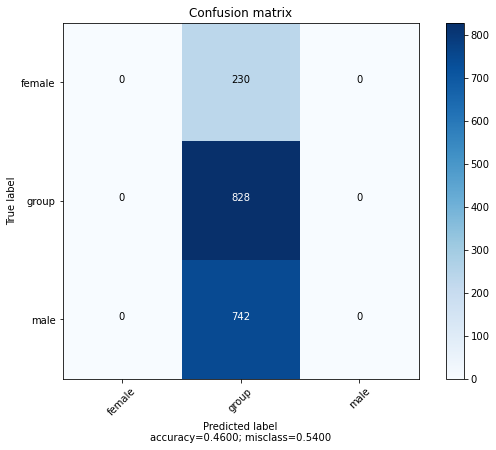

In [79]:
cm = confusion_matrix(g_y_dev, g_dumb_predictions_dev)

plot_confusion_matrix(cm = cm, target_names = ["female","group","male"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [80]:
# get the performance on the testing set
g_dumb_predictions_test = g_most_frequent.predict(g_X_base_test)

print(classification_report(g_y_test,g_dumb_predictions_test))
print("F1 micro:", f1_score(g_y_test, g_dumb_predictions_test, average = "micro"))

              precision    recall  f1-score   support

      female       0.00      0.00      0.00       272
       group       0.47      1.00      0.64       855
        male       0.00      0.00      0.00       691

    accuracy                           0.47      1818
   macro avg       0.16      0.33      0.21      1818
weighted avg       0.22      0.47      0.30      1818

F1 micro: 0.47029702970297027


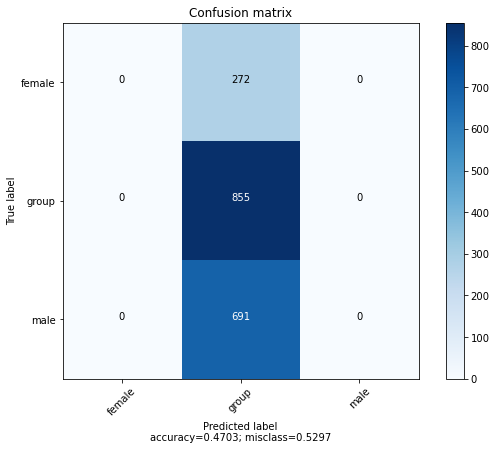

In [81]:
cm = confusion_matrix(g_y_test, g_dumb_predictions_test)

plot_confusion_matrix(cm = cm, target_names = ["female","group","male"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

### 2nd BASELINE - THE HULK <a name="hulk2"></a>

In [82]:
# FIT BASELINE
g_lr_base = LogisticRegression(max_iter = 150, solver = "sag", random_state = 1)
g_lr_base.fit(g_X_base_train, g_y_train)

LogisticRegression(max_iter=150, random_state=1, solver='sag')

In [83]:
# TRAINING
g_pred_base_train = g_lr_base.predict(g_X_base_train)
print("Training - Classification Report:")
print()
print(classification_report(g_y_train, g_pred_base_train))
print("F1 micro:", f1_score(g_y_train, g_pred_base_train, average = "micro"))

Training - Classification Report:

              precision    recall  f1-score   support

      female       0.96      0.29      0.44      1704
       group       0.77      0.93      0.85      6072
        male       0.83      0.83      0.83      5224

    accuracy                           0.80     13000
   macro avg       0.85      0.68      0.71     13000
weighted avg       0.82      0.80      0.79     13000

F1 micro: 0.8045384615384615


In [84]:
# DEV
g_pred_base_dev = g_lr_base.predict(g_X_base_dev)
print("Dev - Classification Report:")
print()
print(classification_report(g_y_dev, g_pred_base_dev))
print("F1 micro:", f1_score(g_y_dev, g_pred_base_dev, average = "micro"))

Dev - Classification Report:

              precision    recall  f1-score   support

      female       0.41      0.04      0.07       230
       group       0.55      0.75      0.64       828
        male       0.58      0.51      0.54       742

    accuracy                           0.56      1800
   macro avg       0.51      0.43      0.42      1800
weighted avg       0.54      0.56      0.52      1800

F1 micro: 0.5594444444444444


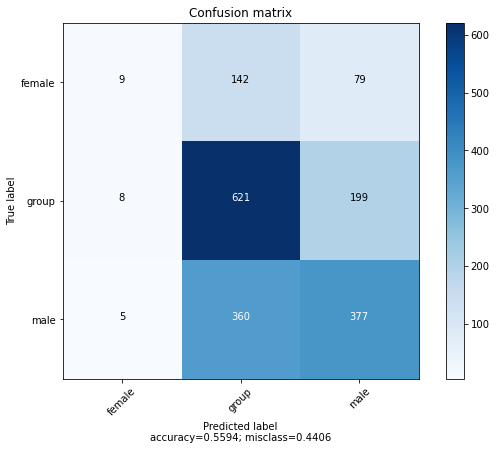

In [85]:
cm = confusion_matrix(g_y_dev, g_pred_base_dev)

plot_confusion_matrix(cm = cm, target_names = ["female","group","male"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [87]:
# TEST
g_pred_base_test = g_lr_base.predict(g_X_base_test)
print("Testing - Classification Report:")
print()
print(classification_report(g_y_test, g_pred_base_test))
print("F1 micro:", f1_score(g_y_test, g_pred_base_test, average = "micro"))

Testing - Classification Report:

              precision    recall  f1-score   support

      female       0.45      0.05      0.09       272
       group       0.58      0.77      0.66       855
        male       0.55      0.53      0.54       691

    accuracy                           0.57      1818
   macro avg       0.53      0.45      0.43      1818
weighted avg       0.55      0.57      0.53      1818

F1 micro: 0.5693069306930693


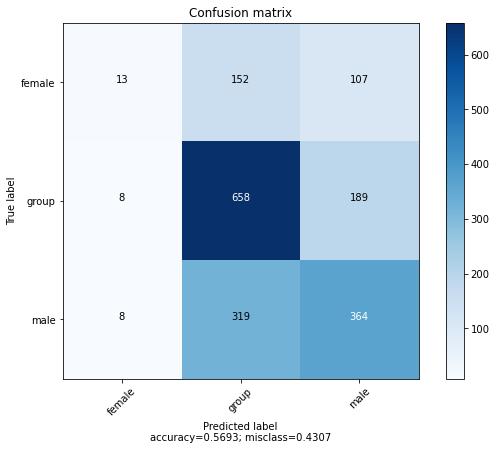

In [88]:
cm = confusion_matrix(g_y_test, g_pred_base_test)

plot_confusion_matrix(cm = cm, target_names = ["female","group","male"],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

## CONVOLUTIONAL NEURAL NETWORK <a name="cnn"></a>

For this task I decided to experiment with convolutional neural networks, mainly tweaking batch size, number of epochs as well as some other factors like embeddings dimensions, hidden imensions, number of convolutional layers and activation functions. Best results were obtained with 3 epochs, and a batch size of 62.  

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation

In [2]:
# train_data = pd.read_csv("data/train_decade.csv").iloc[:,1:]
# dev_data = pd.read_csv("data/dev_decade.csv").iloc[:,1:]
# test_data = pd.read_csv("data/test_decade.csv").iloc[:,1:]

# data = pd.concat([train_data,dev_data,test_data])

train_data = pd.read_csv("data/train_gender.csv").iloc[:,1:]
dev_data = pd.read_csv("data/dev_gender.csv").iloc[:,1:]
test_data = pd.read_csv("data/test_gender.csv").iloc[:,1:]

data = pd.concat([train_data,dev_data,test_data])

When working with a convolutional neural network, after specifying target and input column, we need to map each label and token to an integer, and can do so through the following function.

In [3]:
def convert2ints(instances):
    """
    function to apply the mapping to all words
    """
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words] 
        result.append(word_ints)
    return result

Naturally, we'll need to also store some dictionaries mapping each word to their respective integer and viceversa. There are also 2 special integer for padding and unknown words (0 and 1 respectively).

In [4]:
target = 'gender'
input_column = 'lemma'

train_instances = train_data[input_column].apply(str).apply(str.split)
train_labels = train_data[target]

# collect known word tokens and tags
wordset, labelset = set(), set()

# collect tags from all data, to prevent unseen labels
labelset.update(set(data[target]))

# get the vocabulary
for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
label2int = {label: i for i, label in enumerate(sorted(labelset))}
# inverted index to translate it back
int2label = {i:label for label, i in label2int.items()}
                          
train_instances_int = convert2ints(train_instances) # list of lists, each inner list is a sequence of integers mapping to a word
train_labels_int = [label2int[label] for label in train_labels] # map each training label to an integer

# convert test data 
test_instances = test_data[input_column].apply(str).apply(str.split)
test_labels = test_data[target]

test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

# convert dev data
dev_instances = dev_data[input_column].apply(str).apply(str.split)
dev_labels = dev_data[target]

dev_instances_int = convert2ints(dev_instances)
dev_labels_int = [label2int[label] for label in dev_labels]

In [5]:
print("Total number of words in vocabulary:", len(word2int))

Total number of words in vocabulary: 84657


We then transform each encoded label to a one hot distribution.

In [6]:
train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

To speed up the process and avoid excessive padding of most of the instances due to a few very long songs, we can cap the instances' length at the 95th percentile.

In [7]:
# compute 95th percentile of training sentence lengths
# pad automatically adds 0s
L = sorted(map(len, train_instances)) # map each training sentence to its length, then sort from shortest to longest
MAX_LENGTH = L[int(len(L)*0.95)] # find 95th quantile of sentence length and use that as max length
print(MAX_LENGTH)

# apply padding, i.e. add a series of 0s to the various instances_int 
from keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH) # telling how much to pad w/ maxlen
test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
dev_instances_int = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH)

print(train_instances[0], len(train_instances[0]))
print(train_instances_int[0], len(train_instances_int[0]))

882
['yo,', "pi'erre,", 'yo,', "pi'erre", 'how', 'you', 'get', 'so', 'much', 'favor', 'on', 'your', 'side?', 'accept', 'him', 'as', 'your', 'lord', 'and', 'saviour,', 'i', 'replied', 'thou', 'shalt', 'love', 'thy', 'neighbor,', 'not', 'divide', "i'ma", 'ride,', "that's", 'on', 'god', 'his', 'light', 'shine', 'the', 'brightest', 'in', 'the', 'dark', 'single', 'mothers', 'know', 'they', 'got', 'my', 'heart', 'and', 'all', 'my', 'brothers', 'locked', 'up', 'on', 'the', 'yard', 'you', 'can', 'still', 'be', 'anything', 'you', 'wanna', 'be', 'went', 'from', 'one', 'in', 'four', 'to', 'one', 'in', 'three', 'thirteenth', 'amendment,', 'gotta', 'end', 'it,', "that's", 'on', 'me', 'he', 'the', 'new', 'commander', 'and', 'the', 'chief', "that's", 'on', 'keef,', "that's", 'on', 'god', 'before', 'the', 'ranch,', 'i', 'had', 'horses', 'in', 'the', 'garage', 'when', 'the', 'forbes', 'cover', 'was', 'just', 'a', 'mirage', 'they', 'had', 'me', "chasin'", 'statues,', "that's", 'on', 'prideoh', 'my', 'go

Now to the actual model.

In [8]:
# make it replicable
np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 50
nb_filter = 64
filter_length = 3
hidden_dims = 32
stride_length = 3

# Functional View

# ~ Give info about input
inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')

# Turns positive integers (indexes) into dense vectors of fixed size. 
embeddings = Embedding(len(word2int), # Size of the vocabulary
                       embedding_dim, # Desired dimension of the dense embedding.
                       input_length = MAX_LENGTH)(inputs) # Length of input sequences, when it is constant. This argument is required if you are going to connect `Flatten` then `Dense` layers upstream (without it, the shape of the dense outputs cannot be computed).


# 1D convolution layer (e.g. temporal convolution). This layer creates a convolution kernel that is convolved
# with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
convolution = Conv1D(filters = nb_filter,  # Number of filters to use
                    kernel_size = filter_length, # n-gram range of each filter (~window)
                    padding='same',  # valid: don't go off edge; same: use padding before applying filter
                    activation='relu', 
                    strides=stride_length)(embeddings) # specifying the stride length of the convolution (stride = step)

# 2nd convolution layer
convolution2 = Activation(activation='tanh')(convolution)

pooling = GlobalMaxPooling1D()(convolution2)

# Reached this point we do a fully connected neural network with some hidden layers, 2 here
# The Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps
# PREVENT OVERFITTING. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
dropout1 = Dropout(0.4)(pooling) # rate = Float between 0 and 1. Fraction of the input units to drop
dense = Dense(hidden_dims, activation='relu')(dropout1)
dropout2 = Dropout(0.4)(dense)
output = Dense(len(label2int), activation='softmax')(dropout2)

model = Model(inputs=[inputs], outputs=[output])

#this is our final model /architecture we have built
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# get alist of all the layers and their size
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 882)]             0         
                                                                 
 embedding (Embedding)       (None, 882, 50)           4232850   
                                                                 
 conv1d (Conv1D)             (None, 294, 64)           9664      
                                                                 
 activation (Activation)     (None, 294, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

In [11]:
batch_size = 62
epochs = 5

# The batch size is a number of samples processed before the model is updated, how often it back propagates.
# The number of epochs is the number of complete passes through the training dataset.
# The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

history = model.fit(train_instances_int, train_labels_1hot, # X, y
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_instances_int, dev_labels_1hot)
                   )

Epoch 1/3
210/210 [==============================] - 18s 85ms/step - loss: 0.1508 - accuracy: 0.9514 - val_loss: 1.6563 - val_accuracy: 0.5228
Epoch 2/3
210/210 [==============================] - 18s 87ms/step - loss: 0.1196 - accuracy: 0.9636 - val_loss: 1.7610 - val_accuracy: 0.5089
Epoch 3/3
210/210 [==============================] - 17s 81ms/step - loss: 0.0996 - accuracy: 0.9689 - val_loss: 1.8699 - val_accuracy: 0.5150


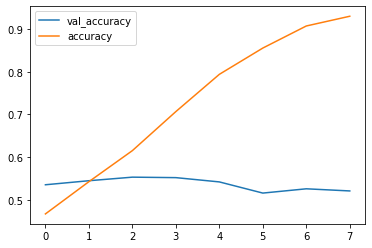

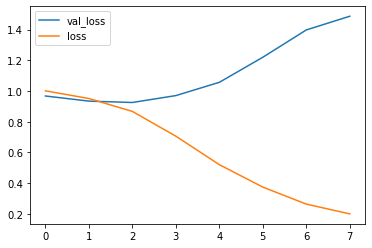

In [10]:
%matplotlib inline
df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line(); # val = validation / dev
df[['val_loss', 'loss']].plot.line();

Finally I evaluated the test accuracy.

In [101]:
loss, accuracy = model.evaluate(test_instances_int, test_labels_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5583


Unfortunately, playing with the batch size and the other parameters was not enough to reach a result that could beat the baseline on the dev set nor on the test. The main worth mentioning steps I took were:
- slightly reducing the embedding dimensions to reduce the overall number of parameters, which could be the main problem associated with the poor performance, given the size of the dataset;
- increasing the dropout rate, as the training score in some cases reached very high values, which led me to think there was a overfitting problem;
- Very minor reductions to the batch size allowed to increase the dev score by a few percentage points, which could however be just due to chance.
- Working with the raw lyrics instead of the lemmas did not negatively affect the performance.